In [ ]:
import pandas as pd
from google.colab import drive
import random
import numpy as np
import torch

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
problem_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Khuad_최종플젝/problem_processed.csv')

In [ ]:
problem_df.columns.values[1] = 'problem_id'
problem_df.columns.values[10] = 'problem_tags'

problem_df['problem_id'] = problem_df['problem_id'].astype(str)

In [ ]:
problem_df

,Unnamed: 0.1,problem_id,titleKo,titles,isSolvable,acceptedUserCount,level,givesNoRating,averageTries,official,problem_tags,Unnamed: 0,0
0,0,1000,A+B,"[{'language': 'en', 'languageDisplayName': 'en...",True,248747,1,False,2.4906,True,"implementation,arithmetic,math,",0,1000
1,1,1001,A-B,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,211935,1,False,1.4210,True,"implementation,arithmetic,math,",1,1001
2,2,1002,터렛,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,33220,8,False,4.4786,True,"case_work,geometry,math,",2,1002
3,3,1003,피보나치 함수,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,45403,8,False,3.0812,True,"dp,",3,1003
4,4,1004,어린 왕자,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,13610,8,False,2.1913,True,"geometry,math,",4,1004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7139,7139,24954,물약 구매,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,215,10,False,1.8140,True,"bruteforcing,implementation,",7625,24954
7140,7140,24955,숫자 이어 붙이기,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,129,12,False,3.0853,True,"bfs,dfs,graphs,graph_traversal,lca,math,trees,",7626,24955
7141,7141,24956,나는 정말 휘파람을 못 불어,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,181,12,False,3.5967,True,"combinatorics,dp,math,",7627,24956
7142,7142,24968,트리의 간선 바꾸기,"[{'language': 'ko', 'languageDisplayName': 'ko...",True,5,21,False,2.2000,True,"euler_tour_technique,lca,prefix_sum,trees,",7628,24968


In [ ]:
problem_level_seq_list = []

group_df = problem_df.groupby('level')

for level, df in group_df:
    problem_level_seq_list.append(df['problem_id'].tolist())

print(len(problem_level_seq_list))
for i in problem_level_seq_list:
  print(i)

30
['1000', '1001', '1008', '1271', '1330', '2338', '2420', '2438', '2475', '2557', '2558', '2738', '2739', '2741', '2743', '2744', '2753', '2754', '3003', '4101', '4999', '5337', '5338', '5339', '5522', '5597', '7287', '8393', '9086', '9498', '9653', '9654', '10171', '10172', '10430', '10699', '10718', '10757', '10807', '10869', '10871', '10872', '10926', '10950', '10951', '10952', '10998', '11021', '11022', '11382', '11654', '11718', '11942', '13277', '14581', '14645', '14652', '14681', '14928', '15680', '15727', '15733', '15740', '15962', '15964', '16170', '16394', '16430', '17256', '18108', '20492', '21598', '24262', '24900']
['1264', '2083', '2439', '2440', '2480', '2530', '2742', '2752', '2845', '4299', '4470', '5524', '5532', '5543', '5554', '5575', '5596', '5717', '10039', '10101', '10156', '10768', '10797', '10808', '11282', '11283', '11365', '11720', '11943', '11945', '11948', '13118', '13136', '13752', '13866', '14470', '14489', '14924', '14935', '15439', '15552', '15700', '

In [ ]:
problem_tag_seq_list = []

tag_list = []

def get_preprocessing_tags(tags):
    global tag_list
    # tags = eval(tags)
    if type(tags) != 'float':
      tags = str(tags).split(',')
      tags.pop()
      tags = [tag for tag in tags]
      tag_list += tags
    return tags

problem_df['preprocessing_tags'] = problem_df['problem_tags'].apply(lambda x : get_preprocessing_tags(x))
tag_list = list(set(tag_list))
problem_num_list = problem_df['problem_id'].tolist()

tag_df = pd.DataFrame(data = np.zeros((len(problem_num_list), len(tag_list))), columns = tag_list, index = problem_num_list)

for df in problem_df.iloc:
    tag_df.loc[df['problem_id'], df['preprocessing_tags']] = 1

for tag in tag_list:
    problem_tag_seq = tag_df[tag_df[tag] == 1].index.tolist()
    problem_tag_seq_list.append(problem_tag_seq)

len(problem_tag_seq_list)

187

In [ ]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.callbacks import CallbackAny2Vec
import datetime

class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 1
        self.loss_to_be_subed = 0
        self.loss_now = 987654321

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed

        self.loss_to_be_subed = loss
        print(loss_now, self.loss_now)
        if loss_now < self.loss_now:
            self.loss_now = loss_now
            # model.save(os.path.join(MODEL_PATH, 'clean-Word2Vec-CBOW-problem_association_seq-problem_level_seq-problem_tag_seq-vs128.model'))
            print(f'Loss after epoch {self.epoch}: {loss_now}')
            # print('Model 저장')
        self.epoch += 1

start = datetime.datetime.now()

sentences = problem_level_seq_list + problem_tag_seq_list

model = Word2Vec(
                sentences = sentences,
                seed = 22,
                epochs = 300,
                min_count = 1,
                vector_size = 128,
                sg = 0,
                negative = 10,
                window = 987654321,
                compute_loss = True,
                callbacks=[callback()],
                 )

print("Time passed: " + str(datetime.datetime.now() - start))

48090.73046875 987654321
Loss after epoch 1: 48090.73046875
35892.00390625 48090.73046875
Loss after epoch 2: 35892.00390625
34748.21875 35892.00390625
Loss after epoch 3: 34748.21875
34367.3125 34748.21875
Loss after epoch 4: 34367.3125
34211.34375 34367.3125
Loss after epoch 5: 34211.34375
33653.390625 34211.34375
Loss after epoch 6: 33653.390625
32375.015625 33653.390625
Loss after epoch 7: 32375.015625
31255.234375 32375.015625
Loss after epoch 8: 31255.234375
29826.40625 31255.234375
Loss after epoch 9: 29826.40625
28670.03125 29826.40625
Loss after epoch 10: 28670.03125
27656.0625 28670.03125
Loss after epoch 11: 27656.0625
27101.46875 27656.0625
Loss after epoch 12: 27101.46875
26362.4375 27101.46875
Loss after epoch 13: 26362.4375
25573.03125 26362.4375
Loss after epoch 14: 25573.03125
24707.03125 25573.03125
Loss after epoch 15: 24707.03125
24169.34375 24707.03125
Loss after epoch 16: 24169.34375
23476.40625 24169.34375
Loss after epoch 17: 23476.40625
22692.34375 23476.40625


In [ ]:
ids = problem_df["problem_id"].to_list()
vectors = []
for id in ids:
  vectors.append(model.wv[id])
vectors = np.array(vectors)

In [ ]:
vectors.shape

(7144, 128)

## Cosine 유사도를 이용한 근접 문제 뽑기


In [ ]:
from numpy.linalg import norm
from numpy import dot

In [ ]:
def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

In [ ]:
indices = pd.Series(problem_df.index, index=problem_df['problem_id'])

problem_id
1000    0
1001    1
1002    2
1003    3
1004    4
dtype: int64


In [ ]:
def recommendation_problem(word):
  idx = indices[word]
  sim_scores = []
  for i in range(len(vectors)):
    similarity_score = cos_sim(vectors[idx], vectors[i])
    sim_scores.append([i ,similarity_score])
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:31]
  word_index = [i[0] for i in sim_scores]
  return problem_df['problem_id'].iloc[word_index].values

In [ ]:
recommends = recommendation_problem('1001')
recommends

array(['1008', '1000', '2753', '2475', '2420', '10950', '2558', '17256',
       '10952', '10951', '3003', '11021', '15964', '10430', '11022',
       '10869', '11382', '10998', '5575', '5596', '10757', '2845',
       '16199', '15552', '16204', '14489', '5554', '13866', '11948',
       '23795'], dtype=object)

In [ ]:
 problem_df[problem_df['problem_id'] == '1001'][['problem_id','titleKo', 'level', 'preprocessing_tags']]

,problem_id,titleKo,level,preprocessing_tags
1,1001,A-B,1,"[implementation, arithmetic, math]"


In [ ]:
#추천 10문제 비교
reco_df = problem_df[problem_df['problem_id'].isin(recommends)][['problem_id','titleKo', 'level', 'preprocessing_tags']]
reco_df

,problem_id,titleKo,level,preprocessing_tags
0,1000,A+B,1,"[implementation, arithmetic, math]"
8,1008,A/B,1,"[implementation, arithmetic, math]"
1263,2420,사파리월드,1,"[implementation, arithmetic, math]"
1316,2475,검증수,1,"[implementation, arithmetic, math]"
1395,2558,A+B - 2,1,"[implementation, arithmetic, math]"
1569,2753,윤년,1,"[implementation, arithmetic, math]"
1648,2845,파티가 끝나고 난 뒤,2,"[implementation, arithmetic, math]"
1786,3003,"킹, 퀸, 룩, 비숍, 나이트, 폰",1,"[implementation, arithmetic, math]"
2416,5554,심부름 가는 길,2,"[implementation, arithmetic, math]"
2430,5575,타임 카드,2,"[arithmetic, implementation, math]"


## T-SNE를 이용한 시각화

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state = 0)
tsne_vectors = tsne.fit_transform(vectors)

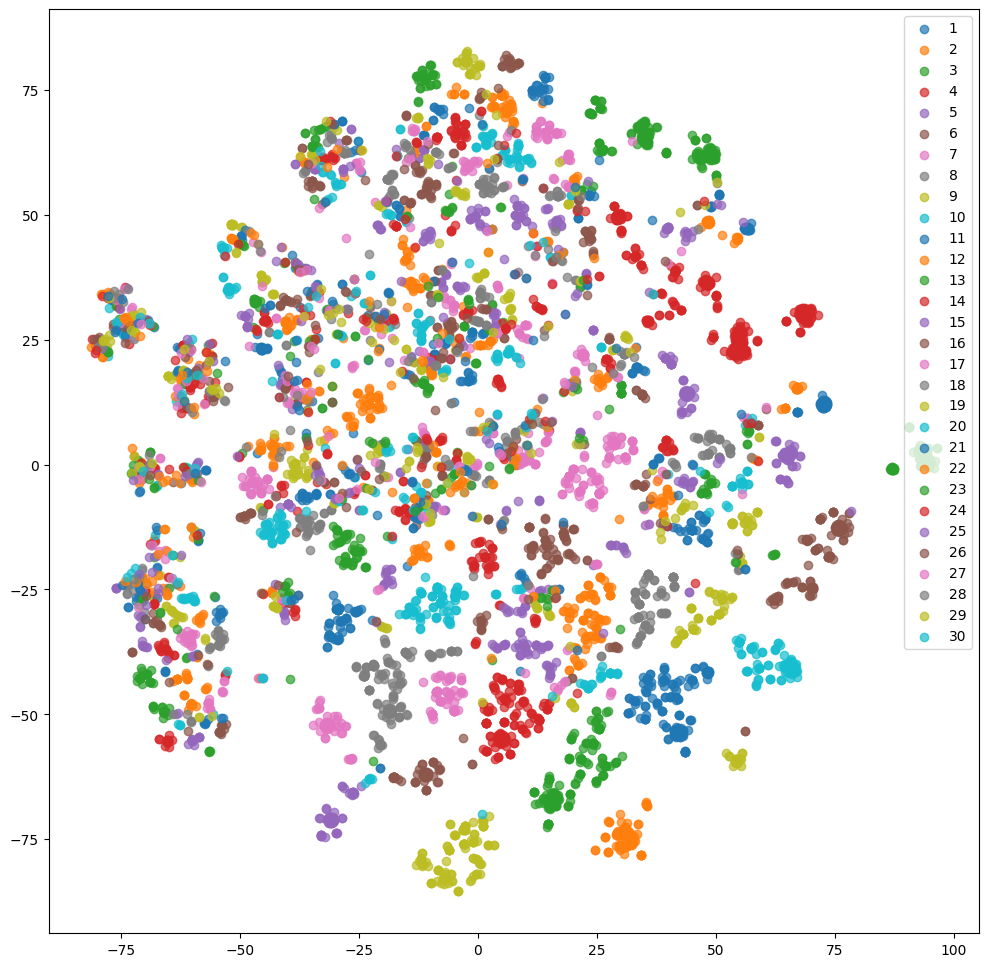

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 12))
problem_df.rename(columns={"Unnamed: 0.1":"id_to_idx"},inplace=True)
for level in sorted(problem_df['level'].unique()):
    idx = problem_df[problem_df['level'] == level]['id_to_idx'].tolist()
    idx = list(map(int, idx))
    #idx = clean_idx(idx)
    plt.scatter(x = tsne_vectors[idx, 0], y = tsne_vectors[idx, 1], alpha = 0.7, label = f'{level}')

plt.legend()
plt.show()